In [1]:
from extract_data import get_data_from_directory
from preprocessing import preprocess
from takagi_sugeno_fnn import TS_FNN

import pandas as pd
import random

In [2]:
data = list(get_data_from_directory('./decoded'))
data = preprocess(data)

In [3]:
pathology_diagnoses = ['H25', 'H26', 'H40']

for d in data:
    d['pathology'] = 1 \
        if any(d['main_diag'].startswith(p_d) for p_d in pathology_diagnoses) or \
           any(any(diag.startswith(p_d) for p_d in pathology_diagnoses) for diag in d['diag']) else 0
len(data)

4037

In [4]:
random.shuffle(data)
test_split = 0.1
split_index = int(test_split * len(data))
test_data, train_data = data[:split_index], data[split_index:]

In [5]:
dataframe = pd.DataFrame(data)
dataframe[:20]

,sex,main_diag,diag,diabetes,age,right_native,correction_right_sphere,correction_right_cylinder,corrected_right,left_native,correction_left_sphere,correction_left_cylinder,corrected_left,pathology
0,f,H25.0,[Z96.1],False,74,0.2,0.00,0.00,0.2,0.5,0.00,0.75,0.7,1
1,f,H52.0,[],False,9,0.7,0.75,0.00,1.0,0.8,0.50,0.00,1.0,0
2,f,H10.2,[H52.4],False,67,0.7,0.75,0.00,1.0,0.4,0.00,0.00,0.4,0
3,m,H35.0,[],False,60,0.1,-1.25,0.00,1.0,1.0,0.00,0.00,1.0,0
4,m,H16.8,[H52.2],False,59,1.0,0.00,0.00,1.0,0.7,0.00,-0.75,1.0,0
5,m,T15.0,[],False,29,1.0,0.00,0.00,1.0,1.0,0.00,0.00,1.0,0
6,f,H52.2,[],False,27,1.0,0.00,0.00,1.0,0.1,0.00,0.00,0.1,0
7,m,H10.5,"[H52.4, H52.2]",False,50,0.8,0.00,0.50,1.0,0.8,0.00,-0.75,1.0,0
8,m,H16.8,"[Z03.9, H17.8]",False,62,0.5,0.25,-3.00,1.0,0.8,0.25,-0.75,1.0,0
9,m,T15.0,[],False,29,1.0,0.00,0.00,1.0,1.0,0.00,0.00,1.0,0


In [6]:
import numpy as np

def abs_max(a, b):
    if abs(a) > abs(b):
        return a
    else:
        return b

def vectorize(data):
    result = []
    for d in data:
        age = int(d['age'])

        # result.append([age, d['pathology'], abs_max(d['correction_right_sphere'], d['correction_right_cylinder']), d['corrected_right']])
        # result.append([age, d['pathology'], abs_max(d['correction_left_sphere'], d['correction_left_cylinder']), d['corrected_left']])
        result.append([age, d['pathology'], d['right_native'], d['corrected_right']])
        result.append([age, d['pathology'], d['left_native'], d['corrected_left']])
    return np.array(result)

def normalize(data):
    return [[d[0]/100, d[1], d[2], d[3]] for d in data]

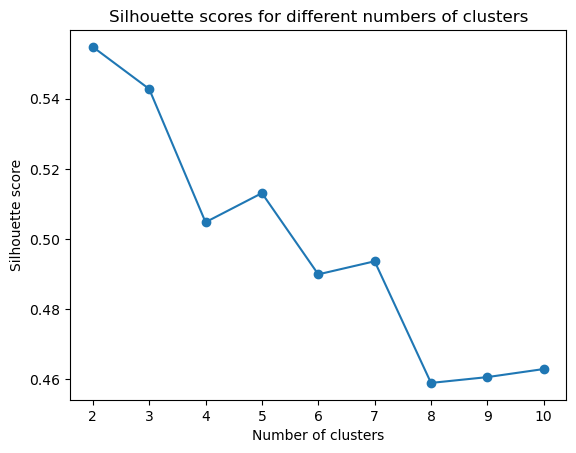

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_scores = []
X = normalize(vectorize(data))

for n_clusters in range_n_clusters:
    # Create KMeans instance
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
    cluster_labels = kmeans.fit_predict(X)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotting the silhouette scores
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores for different numbers of clusters')
plt.xticks(range_n_clusters)
plt.show()

In [8]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto')
kmeans.fit(X)
kmeans.cluster_centers_

array([[4.82674294e-01, 1.88737914e-15, 6.86199499e-01, 9.05352163e-01],
       [7.23266129e-01, 1.00000000e+00, 3.95987903e-01, 5.61580645e-01]])

# Training FNN

In [35]:
vectorized_train_data = normalize(vectorize(train_data))
train_X = np.array([data[0:-1] for data in vectorized_train_data])
train_Y = np.array([data[-1] for data in vectorized_train_data])

ts_fnn = TS_FNN([2, 2, 2], [[0, 0, 0], [1, 1, 1]])
ts_fnn.init_mu_parameters([[0.48, 0.72], [0., 1.], [0.68, 0.39]])
ts_fnn.init_sigma_parameters([[1., 1.], [1., 1.], [1., 1.]])

ts_fnn.fit(train_X, train_Y, epochs=5, learning_rate=0.0001, gradient_accumulation_step=128)
ts_fnn.fit(train_X, train_Y, epochs=5, learning_rate=0.00001, gradient_accumulation_step=128)
# ts_fnn.fit(train_X, train_Y, epoch=10, learning_rate=0.1, gradient_descent_strategy='full')

Iteration 1 Epoch 0 loss 41911.05633
Iteration 2 Epoch 0 loss 24285.03850781438
Iteration 3 Epoch 0 loss 17489.421015228098
Iteration 4 Epoch 0 loss 10226.232854024947
Iteration 5 Epoch 0 loss 8746.04781797717
Iteration 6 Epoch 0 loss 5534.749404080374
Iteration 7 Epoch 0 loss 4577.044964954438
Iteration 8 Epoch 0 loss 3541.6984062948172
Iteration 9 Epoch 0 loss 2393.700003296671
Iteration 10 Epoch 0 loss 2122.8460904499075
Iteration 11 Epoch 0 loss 2213.7266410289144
Iteration 12 Epoch 0 loss 2099.419187209267
Iteration 13 Epoch 0 loss 1830.4544687795562
Iteration 14 Epoch 0 loss 1508.7822367387034
Iteration 15 Epoch 0 loss 1507.1133578680542
Iteration 16 Epoch 0 loss 1598.9552081968784
Iteration 17 Epoch 0 loss 1583.682577957072
Iteration 18 Epoch 0 loss 1152.186331185697
Iteration 19 Epoch 0 loss 1258.4320184713326
Iteration 20 Epoch 0 loss 1445.793384474852
Iteration 21 Epoch 0 loss 1305.505338683935
Iteration 22 Epoch 0 loss 1386.8974678711738
Iteration 23 Epoch 0 loss 1157.567683

KeyboardInterrupt: 

In [38]:
ts_fnn.fit(train_X, train_Y, loss_f='log_likelihood', epoch=5, learning_rate=0.0001, gradient_accumulation_step=128)

TypeError: TS_FNN.fit() got an unexpected keyword argument 'loss_f'

In [36]:
ts_fnn.parameters

(array([[ 0.44958483,  0.72400186],
        [-0.19724562,  1.14474241],
        [ 0.55080861,  0.26167913]]),
 array([[1.00001861, 0.99959421],
        [0.73616809, 0.83561778],
        [1.01847604, 1.01473264]]),
 array([0.68408209, 0.10076171]),
 [array([0.23789712, 0.36961834, 0.31571193]),
  array([ 0.00721071, -0.06961426,  0.75603679])])

In [ ]:
import autograd.numpy as np
from autograd import grad
import autograd.scipy.stats.norm as norm
from autograd.misc.optimizers import adam, sgd

def loss(parameters, t):
    return -logprob(parameters, train_X[:50], train_Y[:50])

def logprob(parameters, X, Y, noise_scale=0.1):
    Y_bar = np.array([ts_fnn.forward(parameters, x) for x in X])
    return np.sum(norm.logpdf(Y_bar, Y, noise_scale))

grad(loss)(ts_fnn.parameters, 0)

(array([[ 8.87619465e-02, -3.30649061e-03],
        [-1.00568472e+00, -1.27118039e+01],
        [ 5.20093829e-01, -1.06215385e-02]]),
 array([[-2.23100973e-02, -5.35383055e-04],
        [-3.69253096e-01,  3.19577539e+01],
        [-3.14632086e-01, -1.73948450e-02]]),
 array([-97.62297471,  -2.67833648]),
 [array([-4.96253447e+01,  9.91543850e-03, -2.24870616e+01]),
  array([ 8.44485093,  1.79892799, 19.43315353])])

# Testing

In [17]:
from testing import r_squared_test

In [37]:
vectorized_test_data = normalize(vectorize(test_data))
test_X = np.array([data[0:-1] for data in vectorized_test_data])
test_Y = np.array([data[-1] for data in vectorized_test_data])
prediction_fun = lambda x: ts_fnn.predict(x)

r_squared_test(prediction_fun, test_X, test_Y)

0.5619945948307223

# Comparisson with linear regression

In [33]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_X, train_Y)

r_squared_test(lambda x: reg.predict([x])[0], test_X, test_Y)

0.5123566227802898